## IMPORT LIBRARIES

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *
import mpl_toolkits.mplot3d 
from sklearn.cluster import KMeans
import ffn as ffn
import empyrical as ep

### UTILITY FUNCTIONS

In [18]:
# Define a function to calculate the ulcer index
def m_ulcer_index(series):
    drawdown = (series - series.cummax()) / series.cummax()
    squared_average = (drawdown ** 2).mean()
    return squared_average ** 0.5

# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y

# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ( (pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2 ) ** 0.5 + ( (pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2 ) ** 0.5,
        2: lambda x, y: abs( (slope * x + intercept) - y ) / (slope ** 2 + 1) ** 0.5,
        3: lambda x, y: abs( (slope * x + intercept) - y )
    }
    return dist_funcs[dist_measure](i, data[i])

### CONSTANTS

In [19]:
n_close_points = 24
n_perc_points = 5
dist_measure = 1
future_candles = 10
pips_y_list = []

In [20]:

data = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
data = data.set_index('time')
# take data from 2007 to 2014
# data = data['2007-01-01':'2007-01-01']
data = data['2007-01-01':'2007-04-01']

# add new columns from the time column, year, month, day, hour, minute
data['year'] = data.index.year
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data

,open,high,low,close,volume,year,month,day_of_week,hour,minute
time,,,,,,,,,,
2007-01-01 21:30:00+00:00,1.95840,1.95860,1.95840,1.95840,18,2007,1,0,21,30
2007-01-01 21:45:00+00:00,1.95840,1.95965,1.95830,1.95920,47,2007,1,0,21,45
2007-01-01 22:00:00+00:00,1.95910,1.96005,1.95890,1.95978,60,2007,1,0,22,0
2007-01-01 22:15:00+00:00,1.96003,1.96190,1.96003,1.96156,91,2007,1,0,22,15
2007-01-01 22:30:00+00:00,1.96138,1.96174,1.96083,1.96174,82,2007,1,0,22,30
...,...,...,...,...,...,...,...,...,...,...
2007-04-01 22:45:00+00:00,1.96870,1.96873,1.96750,1.96778,82,2007,4,6,22,45
2007-04-01 23:00:00+00:00,1.96790,1.96820,1.96745,1.96810,101,2007,4,6,23,0
2007-04-01 23:15:00+00:00,1.96800,1.96810,1.96760,1.96785,64,2007,4,6,23,15


In [ ]:
# loop through the data
# start from the 24th point
for index in range(n_close_points, len(data)):
    try:
        x_close = data['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = data['year'].iloc[j]
        pips_y_dict['month'] = data['month'].iloc[j]
        pips_y_dict['day_of_week'] = data['day_of_week'].iloc[j]
        pips_y_dict['hour'] = data['hour'].iloc[j]
        pips_y_dict['minute'] = data['minute'].iloc[j]
        pips_y_dict['close'] = data['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / data['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = data['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break

pips_y_df = pd.DataFrame(pips_y_list)
pips_y_df_np = pips_y_df.to_numpy()

In [ ]:
np.random.seed(5)
n_clusters = 100
pips_y_df[['day_of_week', 'hour', 'minute']] = StandardScaler().fit_transform(pips_y_df[['day_of_week', 'hour', 'minute']])
pips_y_df_np = pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4', 'day_of_week', 'hour', 'minute']].to_numpy()
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(pips_y_df_np)
pips_y_df['k_label'] = kmeans.labels_
train_pips_y_df = pips_y_df.copy()
k_label_log_ratio_df = train_pips_y_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)

#### CUTTING OFF SOME OF THE WORST PERFORMANCE MODELS 

In [ ]:
import ffn as ffn
import empyrical as ep

best_performing_k_labels_list = []

for m_k_label in k_label_log_ratio_df.index:
    test_pips_y_copy_df = train_pips_y_df[(train_pips_y_df["k_label"] == m_k_label)]
    test_k_label_cumsum = test_pips_y_copy_df["future_log_ratio"].cumsum()
    test_k_label_cumsum = test_k_label_cumsum.reset_index(drop=True)
    if test_k_label_cumsum.iloc[-1] > 0:
        signal = 1
    else:
        signal = 0
        test_k_label_cumsum = -test_k_label_cumsum
    # Add a constant value to the series
    test_k_label_cumsum = test_k_label_cumsum + 100
    n_period = 252
    rf = 0.01
    annualized_return = (
        test_k_label_cumsum.iloc[-1] / test_k_label_cumsum.iloc[0]
    ) ** (1 / 1) - 1
    annualized_std = test_k_label_cumsum.std()
    ulcer_index = m_ulcer_index(test_k_label_cumsum)
    max_drawdown = ffn.calc_max_drawdown(test_k_label_cumsum)
    calmar_ratio = annualized_return / abs(max_drawdown)
    if (
        calmar_ratio > 2
        and ulcer_index < 0.15
        and annualized_return > 0.5
        and abs(max_drawdown) < 0.3
    ):
        best_performing_k_labels_list.append({
            "signal": signal,
            "k_label": m_k_label,
            "calmar_ratio": calmar_ratio,
            "ulcer_index": ulcer_index,
            "annualized_return": annualized_return,
            "max_drawdown": max_drawdown
        })
first_best_performing_k_labels_df = pd.DataFrame(best_performing_k_labels_list)
first_best_performing_k_labels_df

In [ ]:
import random

# m_k_label = random.choice(k_label_log_ratio_df.index)
m_k_label = 39
k_label_sub_df = train_pips_y_df[train_pips_y_df['k_label'] == m_k_label]
for i in range(70):
    k_label_sub_df.iloc[i][['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4']].plot()
plt.title(f'K Label: {m_k_label}')
plt.show()

# TESTING THE MODEL

In [ ]:
test_df = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
test_df = test_df.set_index('time')
# take data from 2007 to 2014
# test_df = test_df['2008-01-01':'2008-06-01']
# test_df = test_df['2007-06-01':'2007-08-01']
test_df = test_df['2007-04-02':'2007-04-20']
# test_df = test_df['2007-05-10':'2007-05-20']

# add new columns from the time column, year, month, day, hour, minute
test_df['year'] = test_df.index.year
test_df['month'] = test_df.index.month
test_df['day_of_week'] = test_df.index.day_of_week
test_df['hour'] = test_df.index.hour
test_df['minute'] = test_df.index.minute
test_df

In [ ]:
n_close_points = 24
n_perc_points = 5
dist_measure = 1
pips_y_list = []
future_candles = 10
for index in range(n_close_points, len(test_df)):
    try:
        x_close = test_df['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x_close, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = test_df['year'].iloc[j]
        pips_y_dict['month'] = test_df['month'].iloc[j]
        pips_y_dict['day_of_week'] = test_df['day_of_week'].iloc[j]
        pips_y_dict['hour'] = test_df['hour'].iloc[j]
        pips_y_dict['minute'] = test_df['minute'].iloc[j]
        pips_y_dict['close'] = test_df['close'].iloc[j]
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / test_df['close'].iloc[j-1])
        # future features
        pips_y_dict['future_close'] = test_df['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_list.append(pips_y_dict)
    except:
        break

pips_y_test_df = pd.DataFrame(pips_y_list)
pips_y_test_df_np = pips_y_test_df.to_numpy()

pips_y_test_df[['day_of_week', 'hour', 'minute']] = StandardScaler().fit_transform(pips_y_test_df[['day_of_week','hour', 'minute']])
pips_y_test_df_np = pips_y_test_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'pip_4', 'day_of_week', 'hour', 'minute']].to_numpy()
y_test_pred = kmeans.predict(pips_y_test_df_np)
pips_y_test_df['k_label'] = y_test_pred
y_test_pips_df = pips_y_test_df.copy()

test_performing_k_labels_list = []
for i in range(len(first_best_performing_k_labels_df)):
    m_k_label = first_best_performing_k_labels_df.iloc[i]['k_label']
    signal = first_best_performing_k_labels_df.iloc[i]['signal']
    test_pips_y_copy_df = y_test_pips_df[(y_test_pips_df["k_label"] == m_k_label)]
    test_k_label_cumsum = test_pips_y_copy_df["future_log_ratio"].cumsum()
    test_k_label_cumsum = test_k_label_cumsum.reset_index(drop=True)
    if signal == 0:
        test_k_label_cumsum = -test_k_label_cumsum
    # Add a constant value to the series
    test_k_label_cumsum = test_k_label_cumsum + 100
    annualized_return = (
        test_k_label_cumsum.iloc[-1] / test_k_label_cumsum.iloc[0]
    ) ** (1 / 1) - 1
    annualized_std = test_k_label_cumsum.std()
    ulcer_index = m_ulcer_index(test_k_label_cumsum)
    max_drawdown = ffn.calc_max_drawdown(test_k_label_cumsum) + 0.000001
    calmar_ratio = annualized_return / abs(max_drawdown)
    if (
        True
        # and calmar_ratio >= 2
        and ulcer_index < 0.15
        and annualized_return > 0.02
        and abs(max_drawdown) < 0.3
    ):
        test_performing_k_labels_list.append({
            "signal": signal,
            "k_label": m_k_label,
            "calmar_ratio": calmar_ratio,
            "ulcer_index": ulcer_index,
            "annualized_return": annualized_return,
            "max_drawdown": max_drawdown 
        })
test_performing_k_labels_df = pd.DataFrame(test_performing_k_labels_list)
test_performing_k_labels_df

## GRAPHS AND ILLUSTRATIONS

array([[<Axes: title={'center': 'pip_0'}>,
        <Axes: title={'center': 'pip_1'}>,
        <Axes: title={'center': 'pip_2'}>,
        <Axes: title={'center': 'pip_3'}>],
       [<Axes: title={'center': 'pip_4'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day_of_week'}>],
       [<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'minute'}>,
        <Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'current_log_ratio'}>],
       [<Axes: title={'center': 'future_close'}>,
        <Axes: title={'center': 'future_return'}>,
        <Axes: title={'center': 'future_log_ratio'}>,
        <Axes: title={'center': 'k_label'}>]], dtype=object)

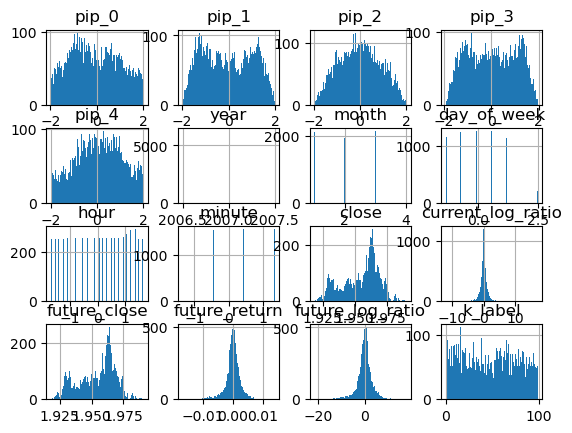

In [12]:
# plot the histogram
pips_y_df.hist(bins=100)

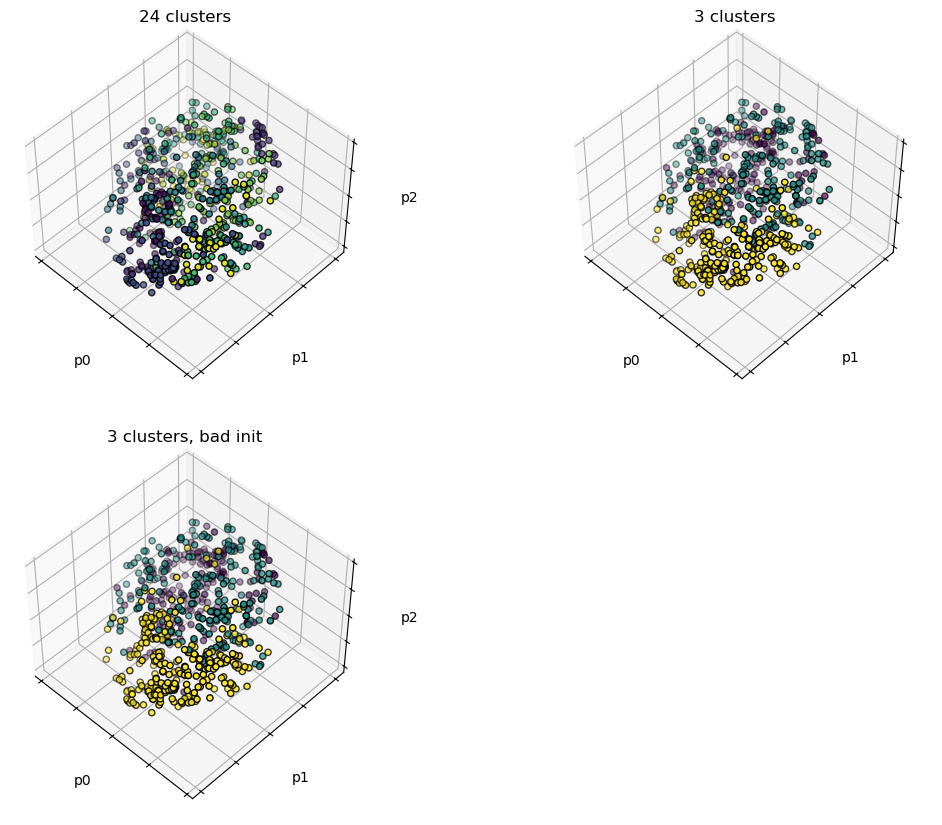

In [11]:
np.random.seed(5)
# X = pips_y_df_np
X = pips_y_df_np[:700]

estimators = [
    ("k_means_24", KMeans(n_clusters=24)),
    ("k_means_3", KMeans(n_clusters=3)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(13, 10))
titles = ["24 clusters", "3 clusters", "3 clusters, bad init"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("p0")
    ax.set_ylabel("p1")
    ax.set_zlabel("p2")
    ax.set_title(title)

plt.show()